In [2]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import torch 
import torch.nn as nn 
# Import tensor dataset & data loader
from torch.utils.data import TensorDataset, DataLoader, Dataset
import cv2
import torchvision.transforms as transforms
import random
from PIL import Image
import torch.optim as optim
from typing import Union, Tuple
import time
from statistics import mean
import torchvision

In [6]:
with np.load('/home/suresh/SoSe2021/Deep-Learning/sose21/Assignments/Assignment4/prediction-challenge-02-data.npz') as fh:
    x_train = fh['x_train']
    y_train = fh['y_train']
    x_test = fh['x_test']

# TRAINING DATA: INPUT (x) AND OUTPUT (y)
# 1. INDEX: IMAGE SERIAL NUMBER (6000)
# 2/3. INDEX: PIXEL VALUE (32 x 32)
# 4. INDEX: COLOR CHANNELS (3)
print(x_train.shape, x_train.dtype)
print(y_train.shape, y_train.dtype)

# TEST DATA: INPUT (x) ONLY
print(x_test.shape, x_test.dtype)

# TRAIN MODEL ON x_train, y_train

# PREDICT prediction FROM x_test

# MAKE SURE THAT YOU HAVE THE RIGHT FORMAT
#assert prediction.ndim == 1
#assert prediction.shape[0] == 300

# AND SAVE EXACTLY AS SHOWN BELOW
#np.save('prediction.npy', prediction.astype(int))

# MAKE SURE THAT THE FILE HAS THE CORRECT FORMAT
def validate_prediction_format():
    loaded = np.load('prediction.npy')
    assert loaded.shape == (300, )
    assert loaded.dtype == int
    assert (loaded <= 2).all()
    assert (loaded >= 0).all()
#validate_prediction_format()


(3000, 32, 32, 3) float32
(3000,) float64
(300, 32, 32, 3) float32


In [3]:
set(y_train)

{0.0, 1.0, 2.0}

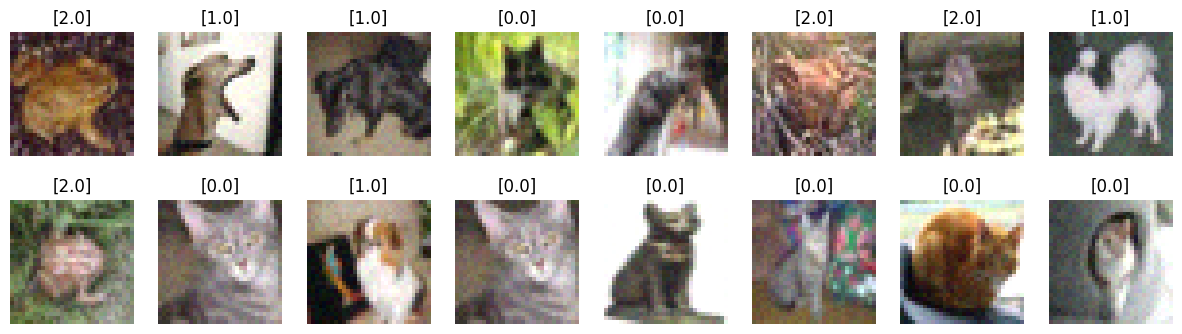

In [7]:
#have a look on some images:

cols = 8
rows = 2
fig = plt.figure(figsize=(2 * cols - 1, 2.5 * rows - 1))
for i in range(cols):
    for j in range(rows):
        random_index = np.random.randint(0, len(y_train))
        ax = fig.add_subplot(rows, cols, i * rows + j + 1)
        ax.grid('off')
        ax.axis('off')
        ax.imshow(x_train[random_index, :])
        ax.set_title([y_train[random_index]])
plt.show()

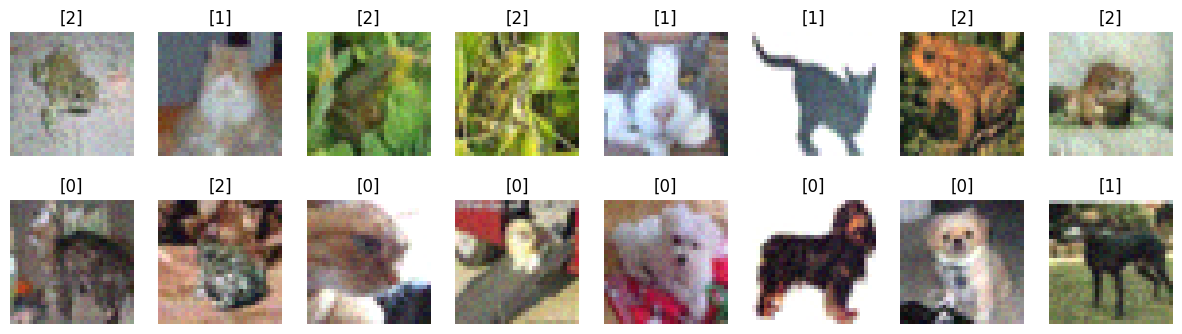

In [9]:
#have a look on some images:

cols = 8
rows = 2
fig = plt.figure(figsize=(2 * cols - 1, 2.5 * rows - 1))
for i in range(cols):
    for j in range(rows):
        random_index = np.random.randint(0, len(prediction))
        ax = fig.add_subplot(rows, cols, i * rows + j + 1)
        ax.grid('off')
        ax.axis('off')
        ax.imshow(x_test[random_index, :])
        ax.set_title([prediction[random_index]])
plt.show()

In [5]:
def preprocess(image):
  
    image = np.array(image)
    
    
    if random.random() > 0.5:
        image = image[::-1,:,:]
    
    cifar_mean = np.array([0.4914, 0.4822, 0.4465]).reshape(1,1,-1)
    cifar_std  = np.array([0.2023, 0.1994, 0.2010]).reshape(1,1,-1)
    
    
    image = (image - cifar_mean) / cifar_std
      
    image = image.transpose(2,1,0)
    return image

In [6]:
def preprocess_test(image):
  
    image = np.array(image)
    
    cifar_mean = np.array([0.4914, 0.4822, 0.4465]).reshape(1,1,-1)
    cifar_std  = np.array([0.2023, 0.1994, 0.2010]).reshape(1,1,-1)
    
    
    image = (image - cifar_mean) / cifar_std
      
    image = image.transpose(2,1,0)
    return image

In [7]:
data=np.array([preprocess(image) for image in x_train])
data_test=np.array([preprocess_test(image) for image in x_test])

In [8]:
#def tensor_reshape(data):
 # tdata = torch.from_numpy(data)
 # tdata = tdata.permute(0, 3, 1, 2)
 # return tdata.numpy()
#data=tensor_reshape(x_train)
#data=data / 255.0
#data_test=tensor_reshape(x_test)
#data_test=data_test / 255.0


In [9]:
X_train, X_val, Y_train, Y_val = train_test_split(data, y_train, test_size=0.30, random_state=42)

In [10]:
inputs = torch.from_numpy(X_train.astype(np.float32))
targets = torch.from_numpy(Y_train.astype(np.float32))
targets = targets.long()
# Define dataset
train_ds = TensorDataset(inputs, targets)

batch_size = 128
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)


In [11]:
inputs = torch.from_numpy(X_val.astype(np.float32))
targets = torch.from_numpy(Y_val.astype(np.float32))
# Define dataset
targets = targets.long()
test_ds = TensorDataset(inputs, targets)
test_loader = DataLoader(test_ds, batch_size=batch_size, shuffle=False)

In [12]:
targets.shape

torch.Size([900])

In [13]:
for x,y in train_loader:
  print(x.shape,y.shape)
  break
def show_random_images(X,y):
    num_samples = 40
    indices = np.random.choice(range(len(X)), num_samples)
    y=y[indices]
    sample_image = X[indices]

    fig = plt.figure(figsize=(20, 6))

    for i in range(num_samples):
        ax = plt.subplot(4, 10, i + 1)
        img = sample_image[i].permute(1, 2, 0)
        plt.imshow(img.numpy())
        plt.title(classes[y[i].item()])
        plt.axis('off')
#show_random_images(x,y)

torch.Size([128, 3, 32, 32]) torch.Size([128])


In [14]:
imgs, lbls = next(iter(train_loader))
print ('Size of image:', imgs.size())  # batch_size*3*224*224
print ('Type of image:', imgs.dtype)   # float32
print ('Size of label:', lbls.size())  # batch_size
print ('Type of label:', lbls.dtype)   # int64(long)

Size of image: torch.Size([128, 3, 32, 32])
Type of image: torch.float32
Size of label: torch.Size([128])
Type of label: torch.int64


In [15]:
class ResidualBlock(nn.Module):
    expansion = 1

    def __init__(self, in_channels, out_channels, stride=1):
        super(ResidualBlock, self).__init__()
        
        # Conv Layer 1
        self.conv1 = nn.Conv2d(
            in_channels=in_channels, out_channels=out_channels,
            kernel_size=(3, 3), stride=stride, padding=1, bias=False
        )
        self.bn1 = nn.BatchNorm2d(out_channels)
        
        # Conv Layer 2
        self.conv2 = nn.Conv2d(
            in_channels=out_channels, out_channels=out_channels,
            kernel_size=(3, 3), stride=1, padding=1, bias=False
        )
        self.bn2 = nn.BatchNorm2d(out_channels)
    
        # Shortcut connection to downsample residual
        # In case the output dimensions of the residual block is not the same 
        # as it's input, have a convolutional layer downsample the layer 
        # being bought forward by approporate striding and filters
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(
                    in_channels=in_channels, out_channels=out_channels,
                    kernel_size=(1, 1), stride=stride, bias=False
                ),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        out = nn.ReLU()(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = nn.ReLU()(out)
        return out
class ResNet(nn.Module):
    def __init__(self, num_classes=3):
        super(ResNet, self).__init__()
        
        # Initial input conv
        self.conv1 = nn.Conv2d(
            in_channels=3, out_channels=64, kernel_size=(3, 3),
            stride=1, padding=1, bias=False
        )
        self.bn1 = nn.BatchNorm2d(64)
        
        # Create blocks
        self.block1 = self._create_block(64, 64, stride=1)
        self.block2 = self._create_block(64, 128, stride=2)
        self.block3 = self._create_block(128, 256, stride=2)
        self.block4 = self._create_block(256, 512, stride=2)
        self.linear = nn.Linear(512, num_classes)
    
    # A block is just two residual blocks for ResNet18
    def _create_block(self, in_channels, out_channels, stride):
        return nn.Sequential(
            ResidualBlock(in_channels, out_channels, stride),
            ResidualBlock(out_channels, out_channels, 1)
        )

    def forward(self, x):
        out = nn.ReLU()(self.bn1(self.conv1(x)))
        out = self.block1(out)
        out = self.block2(out)
        out = self.block3(out)
        out = self.block4(out)
        out = nn.AvgPool2d(4)(out)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out

In [16]:
cuda_available = torch.cuda.is_available()
cuda_available

True

In [17]:
def train(
    model: nn.Module, 
    optimizer: optim.Optimizer, 
    scheduler: optim.Optimizer,
    data: Union[DataLoader, Tuple[DataLoader]], 
    max_epochs: int, 
    cuda=True):
  
  use_test = False
  if isinstance(data, DataLoader):
    train_loader = data
  elif isinstance(data, tuple):
    if len(data) == 2:
      train_loader, test_loader = data
      if not isinstance(train_loader, DataLoader):
        raise TypeError(f'Expected 1st entry of type DataLoader, but got {type(train_loader)}!')
      if not isinstance(test_loader, DataLoader):
        raise TypeError(f'Expected 2nd entry of type DataLoader, but got {type(test_loader)}!')
      use_test = True
    else:
      raise ValueError(f'Expected tuple of length 2, but got {len(data)}!')
  
  
  criterion = nn.CrossEntropyLoss()
  model.train()
  losses = []
  test_losses=[]
  batch_total = len(train_loader)
  train_acc=[]
  test_acc=[]
  best_model=None
  min_loss=np.iinfo(0).max
  for epoch in range(max_epochs):
    samples_total = 0
    samples_correct = 0
    #scheduler.step()
    batch_loss=[]
    for batch_idx, batch in enumerate(train_loader):
      x, y = batch
      if cuda:
        x, y = x.cuda(), y.cuda()
      optimizer.zero_grad()
      output = model(x)
      loss = criterion(output, y)
      loss.backward()
      optimizer.step()
      
      yhat = torch.argmax(output, dim=1)

      samples_total += len(y)
      samples_correct += torch.sum(yhat == y)
      batch_loss.append(loss.item())


    acc = float(samples_correct) / float(samples_total)
    train_acc.append(acc)
    tsamples_total = 0
    tsamples_correct = 0
    test_epoch_loss=[]
    if use_test:
      model.eval()

      for test_x, test_y in test_loader:
        if cuda:
          test_x, test_y = test_x.cuda(), test_y.cuda()
        test_output = model(test_x)
        test_loss = criterion(test_output, test_y)
        test_epoch_loss.append(test_loss.item())
        test_yhat = torch.argmax(test_output, dim=1)
        tsamples_total += len(test_y)
        tsamples_correct += torch.sum(test_yhat == test_y)


      tacc = float(tsamples_correct) / float(tsamples_total)
      test_acc.append(tacc)
      if mean(test_epoch_loss)<min_loss:
            min_loss = mean(test_epoch_loss)
            best_model= model.state_dict()
      model.train()
      sys.stdout.write(f'\rEpoch: {epoch}/{max_epochs}  Loss: {mean(batch_loss):.6f} Acc: {acc:.2%} Test loss: {mean(test_epoch_loss):.6f} Test acc: {tacc:.2%}')
    else:
      sys.stdout.write(f'\rEpoch: {epoch}/{max_epochs}  Loss: {mean(batch_loss):.6f} Acc: {acc:.2%}')
    losses.append(mean(batch_loss))
    test_losses.append(mean(test_epoch_loss))
  return losses,test_losses, train_acc,test_acc, best_model

In [18]:
start = time.time()
model = ResNet()
if cuda_available:
    model = model.cuda()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9, weight_decay=5e-4)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[150, 200], gamma=0.1)
#optimizer = optim.Adam(model.parameters(), lr=1e-3)
losses,test_losses, train_acc,test_acc, best_model = train(model, optimizer,scheduler, (train_loader, test_loader), max_epochs=40,cuda=cuda_available)
end = time.time()
print(f'\nTraining took {end-start}s!')

Epoch: 39/40  Loss: 0.521243 Acc: 76.95% Test loss: 0.882184 Test acc: 60.00%%
Training took 106.47048783302307s!


In [19]:
def plot_loss(epochs,train_losses,test_losses):
  plt.rcParams['figure.figsize'] = [10, 5]
  plt.rcParams['figure.dpi'] = 100
  plt.plot(range(epochs),train_losses, label='train loss')
  plt.plot(range(epochs),test_losses,label='test loss')
  plt.title('MLP')
  plt.legend()
  plt.show()

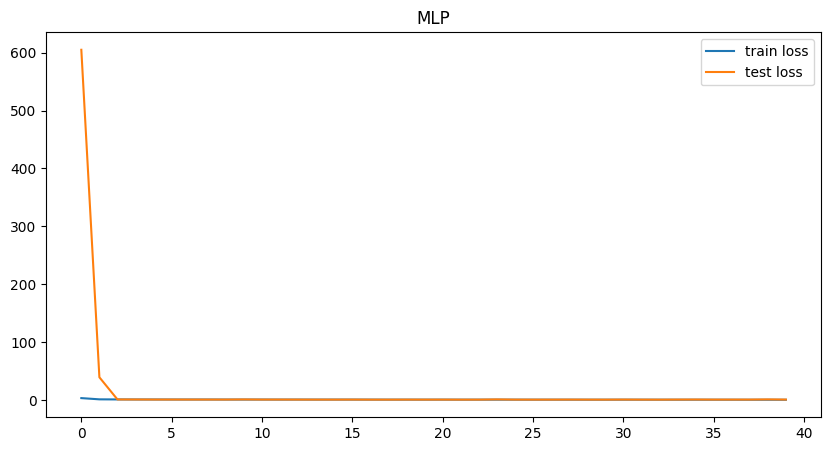

In [20]:
plot_loss(40,losses,test_losses)

In [21]:
def validate(model: nn.Module, data: DataLoader, cuda=True):
  criterion = nn.CrossEntropyLoss()
  losses = []
  correct_samples = 0
  total_samples = 0
  for x, y in data:
      if cuda:
        x, y = x.cuda(), y.cuda()
      output = model(x)
      loss = criterion(output, y)
      yhat = torch.argmax(output, dim=1)
      losses.append(loss.item())
      correct_samples += torch.sum(yhat == y)
      total_samples += len(y)

  mean_losses = np.mean(losses)
  acc = float(correct_samples) / float(total_samples)
  print(f'Validation complete! Validation loss: {mean_losses:.6f}, Validation accuracy: {acc:.2%}')

  return mean_losses, acc

In [22]:
model = ResNet()
if cuda_available:
    model = model.cuda()
model.load_state_dict(best_model)
validate(model, test_loader)


Validation complete! Validation loss: 0.863187, Validation accuracy: 59.33%


(0.8631873391568661, 0.5933333333333334)

In [23]:
test_data=torch.from_numpy(data_test.astype(np.float32))

In [ ]:
output=model.cpu()(test_data)
prediction = torch.argmax(output, dim=1)
prediction=prediction.cpu().numpy()

In [25]:
assert prediction.ndim == 1
assert prediction.shape[0] == 300

# AND SAVE EXACTLY AS SHOWN BELOW
np.save('prediction.npy', prediction.astype(int))

# MAKE SURE THAT THE FILE HAS THE CORRECT FORMAT
def validate_prediction_format():
    loaded = np.load('prediction.npy')
    assert loaded.shape == (300, )
    assert loaded.dtype == int
    assert (loaded <= 2).all()
    assert (loaded >= 0).all()
validate_prediction_format()

In [26]:
prediction.shape

(300,)

In [10]:
np.mean(np.load('prediction.npy')==np.load('prediction2.npy'))

0.6533333333333333

In [12]:
np.load('prediction.npy')

array([2, 2, 1, 2, 2, 2, 1, 0, 2, 0, 1, 0, 0, 1, 1, 2, 2, 1, 1, 2, 1, 0,
       1, 2, 1, 2, 2, 1, 1, 0, 1, 2, 0, 1, 0, 2, 2, 1, 2, 0, 1, 1, 2, 0,
       0, 1, 2, 0, 0, 1, 0, 2, 1, 2, 2, 0, 1, 0, 1, 0, 2, 0, 1, 1, 0, 1,
       2, 1, 2, 2, 2, 0, 0, 2, 2, 1, 2, 1, 2, 0, 1, 0, 2, 1, 0, 0, 0, 1,
       2, 0, 2, 1, 2, 1, 2, 1, 0, 1, 2, 1, 2, 2, 2, 0, 0, 2, 1, 0, 2, 0,
       1, 0, 1, 2, 0, 1, 2, 1, 1, 0, 0, 1, 2, 0, 2, 2, 0, 2, 1, 2, 1, 0,
       0, 1, 1, 2, 2, 0, 1, 0, 0, 2, 0, 0, 0, 1, 2, 2, 1, 0, 1, 0, 1, 2,
       1, 0, 2, 2, 2, 0, 2, 0, 1, 1, 0, 2, 1, 1, 1, 0, 2, 0, 2, 2, 2, 0,
       1, 0, 0, 2, 1, 0, 2, 2, 0, 2, 2, 0, 2, 0, 2, 1, 0, 1, 2, 2, 1, 1,
       0, 2, 1, 0, 2, 0, 0, 2, 2, 1, 1, 1, 1, 1, 2, 0, 1, 1, 2, 2, 0, 1,
       2, 0, 1, 1, 2, 1, 1, 2, 2, 1, 2, 2, 2, 0, 1, 1, 0, 2, 2, 2, 1, 2,
       2, 0, 0, 1, 0, 2, 2, 0, 0, 2, 2, 2, 0, 1, 2, 2, 1, 2, 0, 1, 2, 0,
       1, 0, 0, 2, 1, 0, 2, 2, 0, 0, 0, 0, 1, 2, 2, 0, 2, 2, 0, 0, 2, 0,
       2, 0, 1, 1, 0, 0, 1, 0, 0, 0, 2, 1, 2, 2])

In [13]:
def validate_prediction_format():
    loaded = np.load('prediction.npy')
    assert loaded.shape == (300, )
    assert loaded.dtype == int
    assert (loaded <= 2).all()
    assert (loaded >= 0).all()
validate_prediction_format()